In [47]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

# Download the zip file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as z:
    # Extract the main CSV file
    with z.open('dataset_diabetes/diabetic_data.csv') as f:
        diabetes = pd.read_csv(f)
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


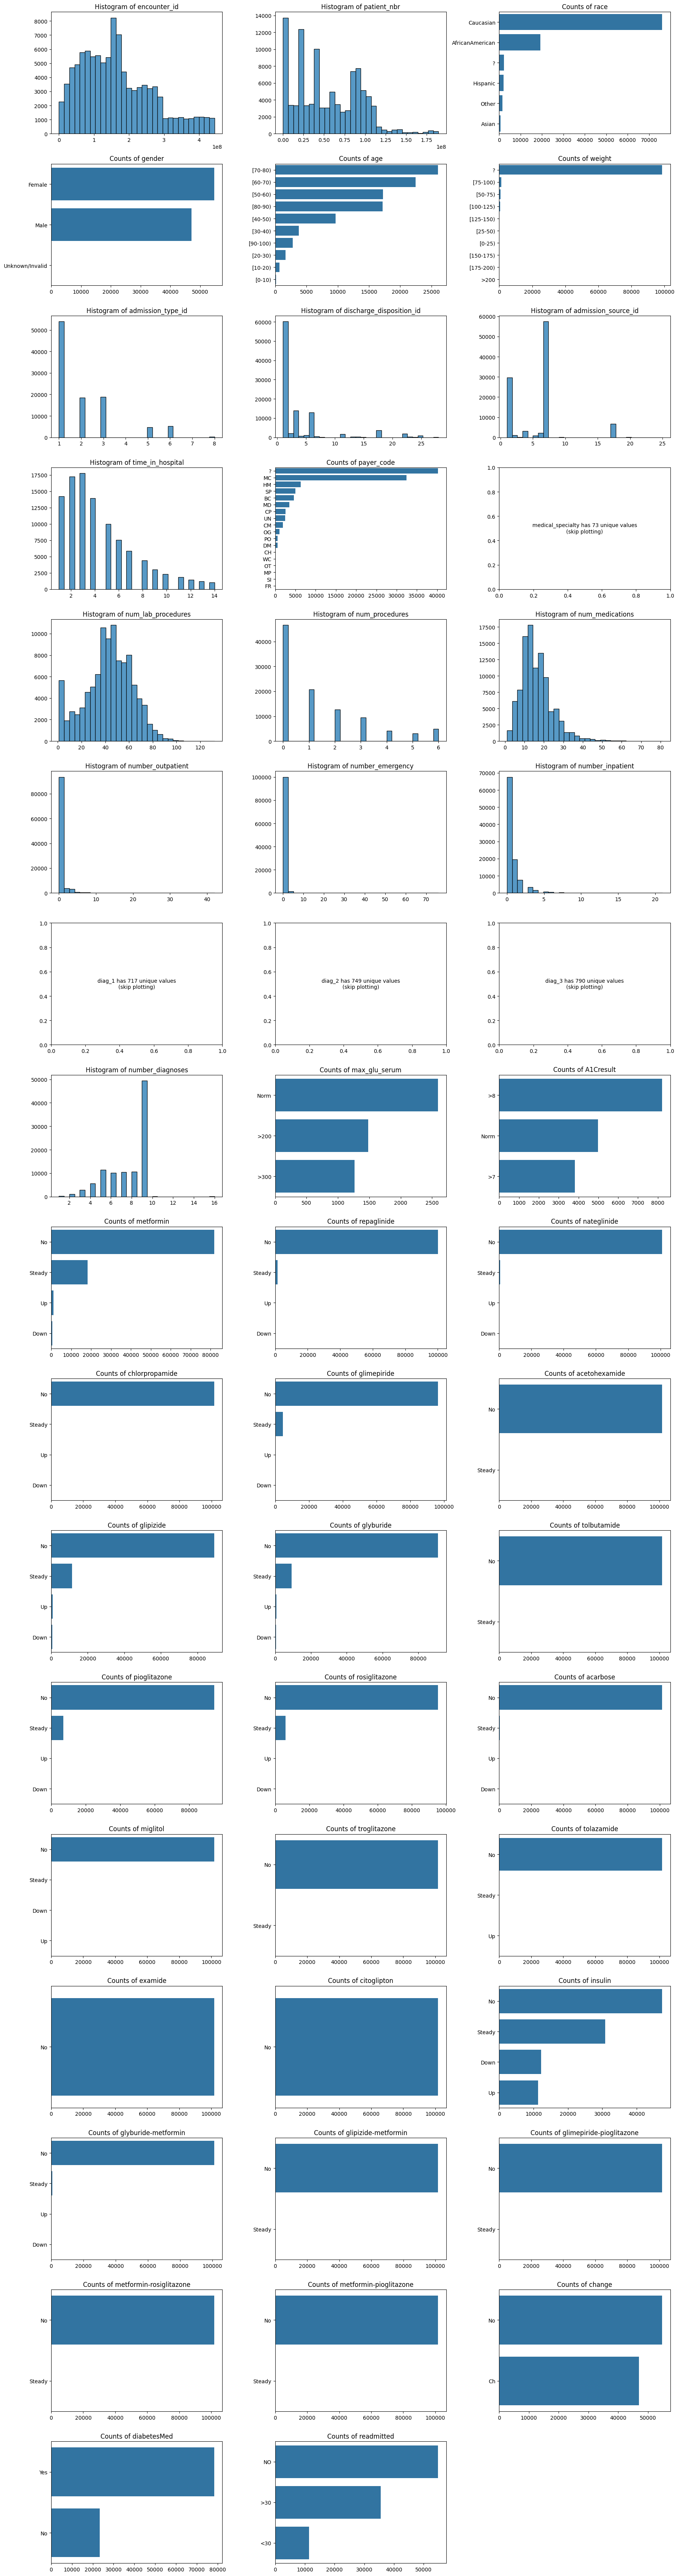

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

#Visualization of all the data distributions to take the best decision about the feautures that will be used in the model 


def plot_all_distributions(df, max_unique=20, bins=30):
    """
    Plot distributions of all columns in a DataFrame.
    - Numeric columns -> histogram
    - Categorical columns -> bar plot (if n_unique <= max_unique)
    """
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(df[col]):
            # Numeric → histogram
            sns.histplot(df[col].dropna(), bins=bins, kde=False, ax=ax)
            ax.set_title(f"Histogram of {col}")
        else:
            # Categorical → bar plot if not too many categories
            n_unique = df[col].nunique()
            if n_unique <= max_unique:
                sns.countplot(y=df[col], order=df[col].value_counts().index, ax=ax)
                ax.set_title(f"Counts of {col}")
            else:
                ax.text(0.5, 0.5, f"{col} has {n_unique} unique values\n(skip plotting)",
                        ha='center', va='center')
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Remove unused axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call function
plot_all_distributions(diabetes)


In [48]:
# Print all unique values in the weight column
print(diabetes["weight"].unique())

# Or, if you also want counts for each category:
print(diabetes["weight"].value_counts())

['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64


In [52]:
# Cleaning Gender, Age and Weight columns
# Clean gender
diabetes = diabetes[diabetes["gender"] != "Unknown/Invalid"]

# Map age into broader bins
def map_age_category(age_str):
    age_str = age_str.strip('[]')
    start, end = age_str.split('-')
    start = int(start)
    end = int(end.replace(')', ''))
    if start < 30:
        return '0-30'
    elif start < 60:
        return '30-60'
    elif start < 90:
        return '60-90'
    else:
        return '90-120'

diabetes["age_group"] = diabetes["age"].apply(map_age_category)

# Drop the messy columns
diabetes = diabetes.drop(columns=["medical_specialty", "diag_1", "diag_2", "diag_3", "weight"])

# Check distributions after cleaning
print("Gender:", diabetes["gender"].unique())
print("Age groups:", diabetes["age_group"].unique())


Gender: ['Female' 'Male']
Age groups: ['0-30' '30-60' '60-90' '90-120']


/var/folders/zn/168nw9p56h9_1x_smvw9yfcr0000gn/T/ipykernel_33224/4062241522.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes["age_group"] = diabetes["age"].apply(map_age_category)


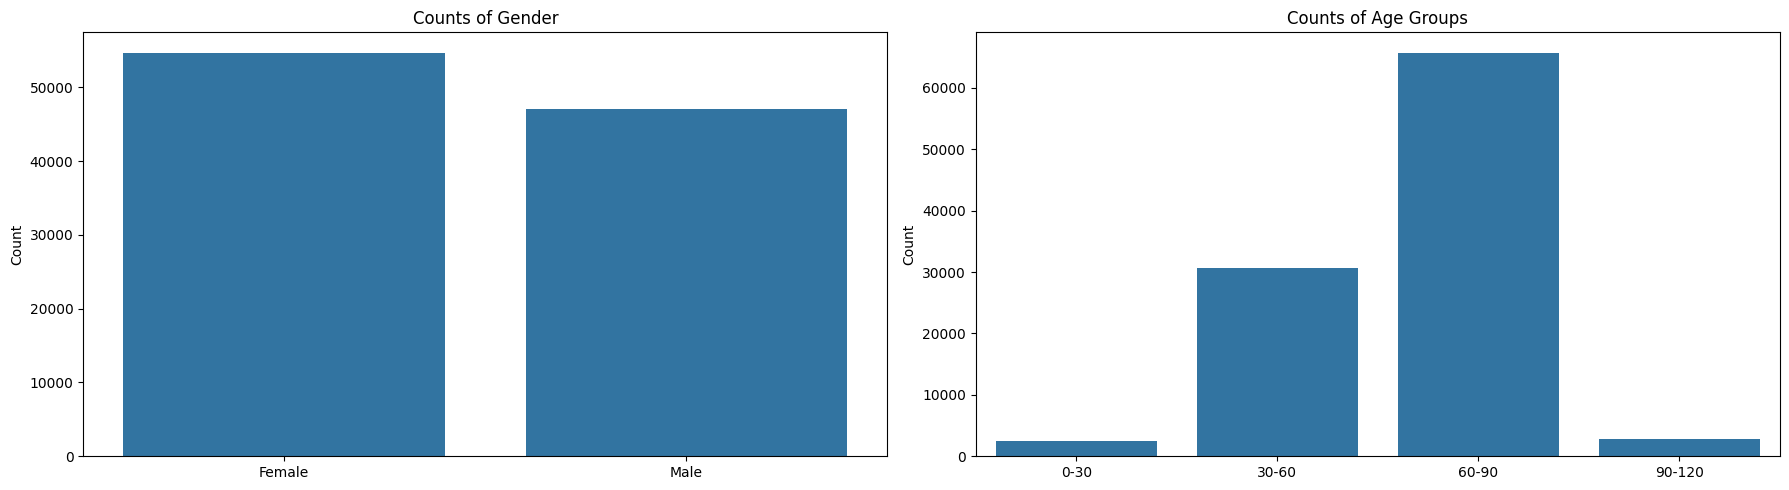

In [54]:
import seaborn as sns

# Order categories for nicer plots
age_order = ["0-30", "30-60", "60-90", "90-120"]
diabetes["age_group"] = pd.Categorical(diabetes["age_group"], categories=age_order, ordered=True)



ig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Gender
sns.countplot(x="gender", data=diabetes, ax=axes[0])
axes[0].set_title("Counts of Gender")
axes[0].set_xlabel("")
axes[0].set_ylabel("Count")

# Age groups
sns.countplot(x="age_group", data=diabetes, order=age_order, ax=axes[1])
axes[1].set_title("Counts of Age Groups")
axes[1].set_xlabel("")
axes[1].set_ylabel("Count")


plt.tight_layout()
plt.show()

In [55]:
diabetes.to_parquet("data/01_main.parquet", index=False)
